In [70]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # скрыть ошибки кода
warnings.filterwarnings('ignore')

%matplotlib inline

In [71]:
import openpyxl as op;
brent = op.load_workbook(r'C:\Users\arina.borisova\Desktop\AD\2 семестр\Datasets\brent1.xlsx');
 
sheet = brent.get_sheet_by_name('нефть brent');
from itertools import islice
data = sheet.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df = pd.DataFrame(data, index=idx, columns=cols)
df.head(10)

,Value
2019-09-01,58.84
2019-08-30,59.19
2019-08-29,60.37
2019-08-28,59.84
2019-08-27,59.59
2019-08-26,58.26
2019-08-25,57.81
2019-08-23,58.94
2019-08-22,60.05
2019-08-21,60.38


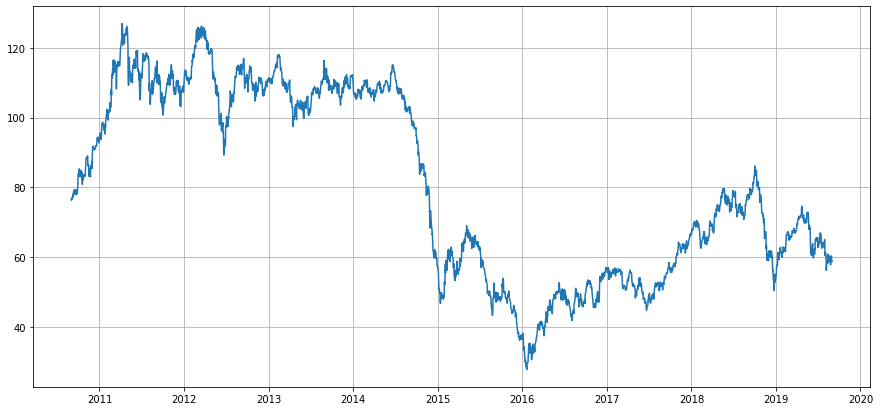

In [73]:
plt.figure(figsize=(15, 7))
plt.plot(df['Value'])
plt.grid(True)
plt.show()

In [75]:
data = pd.DataFrame(df['Value'].copy())
data.columns = ["y"]

In [76]:
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [77]:
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
2010-09-07,77.26,79.10,79.20,78.47,77.97,78.23,79.36,78.10,77.98,77.93,78.80,78.94,78.14,78.85,80.67,82.11,83.81,83.69,83.30,84.65
2010-09-06,76.87,79.19,79.10,79.20,78.47,77.97,78.23,79.36,78.10,77.98,77.93,78.80,78.94,78.14,78.85,80.67,82.11,83.81,83.69,83.30
2010-09-05,76.63,78.36,79.19,79.10,79.20,78.47,77.97,78.23,79.36,78.10,77.98,77.93,78.80,78.94,78.14,78.85,80.67,82.11,83.81,83.69
2010-09-04,76.62,78.41,78.36,79.19,79.10,79.20,78.47,77.97,78.23,79.36,78.10,77.98,77.93,78.80,78.94,78.14,78.85,80.67,82.11,83.81
2010-09-03,76.57,77.21,78.41,78.36,79.19,79.10,79.20,78.47,77.97,78.23,79.36,78.10,77.98,77.93,78.80,78.94,78.14,78.85,80.67,82.11
2010-09-02,76.89,77.93,77.21,78.41,78.36,79.19,79.10,79.20,78.47,77.97,78.23,79.36,78.10,77.98,77.93,78.80,78.94,78.14,78.85,80.67
2010-09-01,76.37,77.26,77.93,77.21,78.41,78.36,79.19,79.10,79.20,78.47,77.97,78.23,79.36,78.10,77.98,77.93,78.80,78.94,78.14,78.85


In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# для рассчета ошибки на кросс-валидации будем бить ряд на 5 фолдов
tscv = TimeSeriesSplit(n_splits=5)

In [79]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(X)*(1-test_size))
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [80]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# разбиваем датасет на тренировочную и тестовую часть, отложим 30% данных
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [81]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [84]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза и аномалий
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

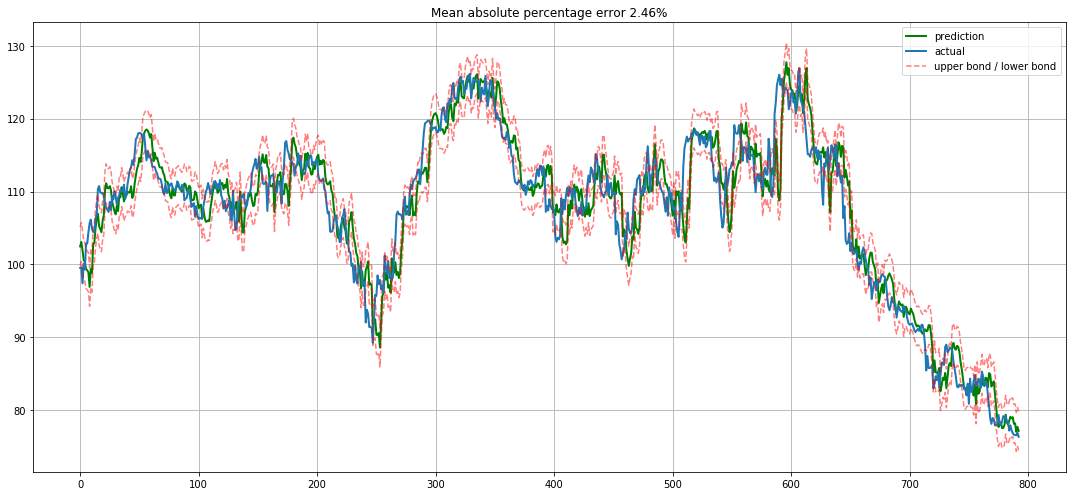

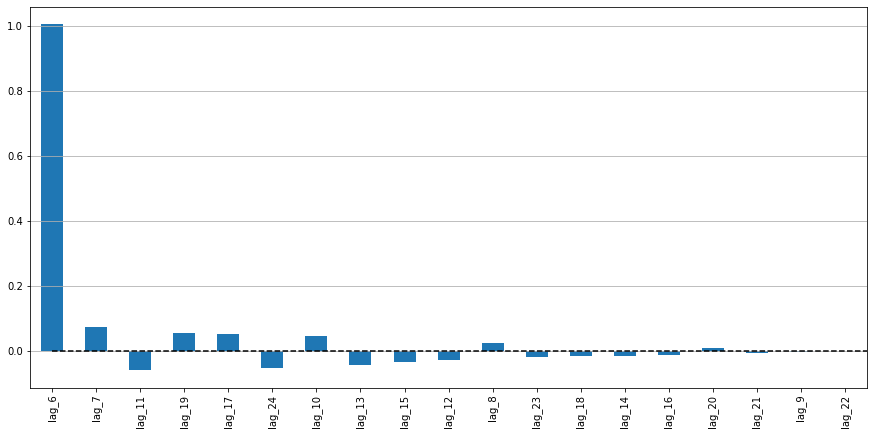

In [85]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [86]:
data.index = data.index.to_pydatetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
2010-09-05,76.63,78.36,79.19,79.10,79.20,78.47,77.97,78.23,79.36,78.10,...,78.94,78.14,78.85,80.67,82.11,83.81,83.69,0,6,1
2010-09-04,76.62,78.41,78.36,79.19,79.10,79.20,78.47,77.97,78.23,79.36,...,78.80,78.94,78.14,78.85,80.67,82.11,83.81,0,5,1
2010-09-03,76.57,77.21,78.41,78.36,79.19,79.10,79.20,78.47,77.97,78.23,...,77.93,78.80,78.94,78.14,78.85,80.67,82.11,0,4,0
2010-09-02,76.89,77.93,77.21,78.41,78.36,79.19,79.10,79.20,78.47,77.97,...,77.98,77.93,78.80,78.94,78.14,78.85,80.67,0,3,0
2010-09-01,76.37,77.26,77.93,77.21,78.41,78.36,79.19,79.10,79.20,78.47,...,78.10,77.98,77.93,78.80,78.94,78.14,78.85,0,2,0


In [88]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

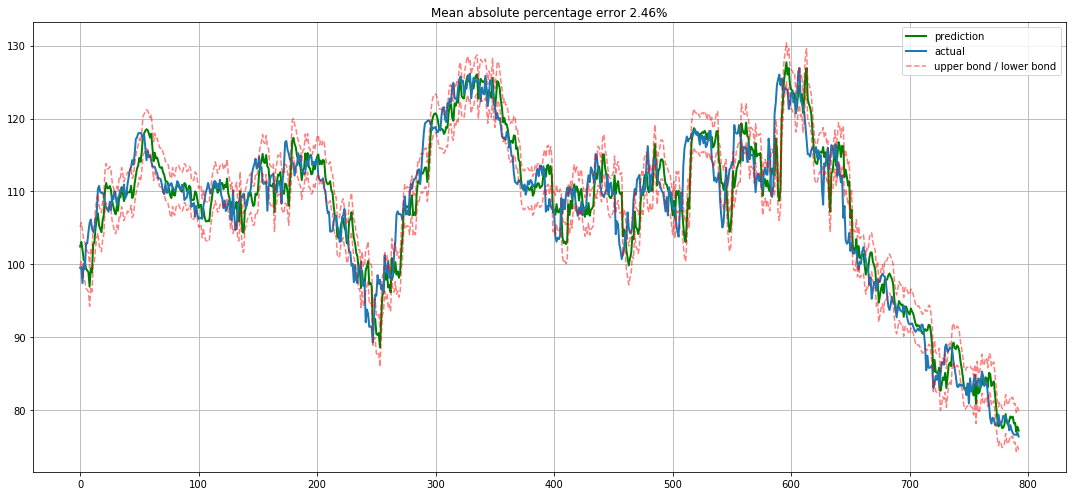

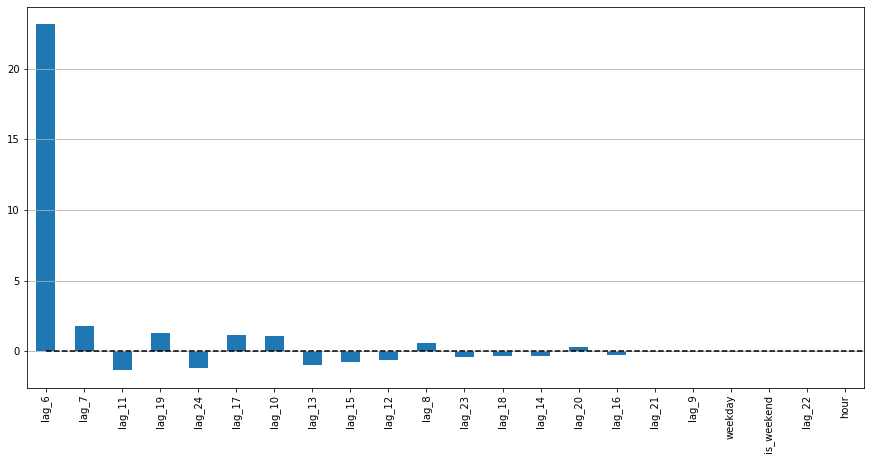

In [89]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# разбиваем датасет на тренировочную и тестовую часть, отложим 30% данных
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)